MACHINE LEARNING MODEL IMPLEMENTATION    
INSTRUCTIONS:

CREATE A PREDICTIVE MODEL USING SCIKIT-LEARN TO CLASSIFY OR PREDICT OUTCOMES FROM A DATASET (E.G., SPAM EMAIL DETECTION).

DELIVERABLE: A JUPYTER NOTEBOOK SHOWCASING THE MODEL'S IMPLEMENTATION AND EVALUATION.

# 1. Import Libraries

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Data Cleaning & Preprocessing

In [17]:
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)


# 3. Train-Test Split

In [18]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4. TF-IDF Vectorizer

In [19]:
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),                  # include bigrams
    stop_words='english',                # removes common words
    lowercase=True
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 5. Train Multiple Models

In [20]:

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced')
}


for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))


Model: Naive Bayes
Accuracy: 0.9704035874439462
F1 Score:               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       965
        Spam       0.99      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Model: Logistic Regression
Accuracy: 0.9757847533632287
F1 Score:               precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       965
        Spam       0.92      0.90      0.91       150

    accuracy                           0.98      1115
   macro avg       0.95      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Model: Random Forest
Accuracy: 0.9713004484304932
F1 Score:               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       965
        Spam       0.99      0.79      0.88       

# 6. Hyperparameter Tuning (Example: Logistic Regression)

In [21]:
pipeline = Pipeline([
    # ('tfidf', TfidfVectorizer(max_features=3000)),
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.9)),
    ('clf', LogisticRegression())
])

params = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2']
}

grid = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
grid.fit(X, y)

print("Best Score:", grid.best_score_)
print("Best Params:", grid.best_params_)

Best Score: 0.9779251435058086
Best Params: {'clf__C': 10, 'clf__penalty': 'l2'}


# 7. Confusion Matrix and ROC Curve

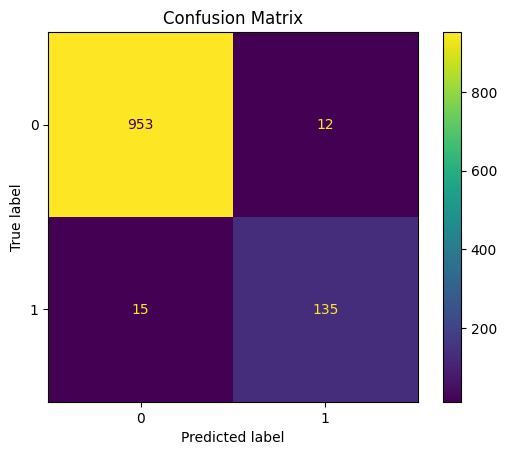

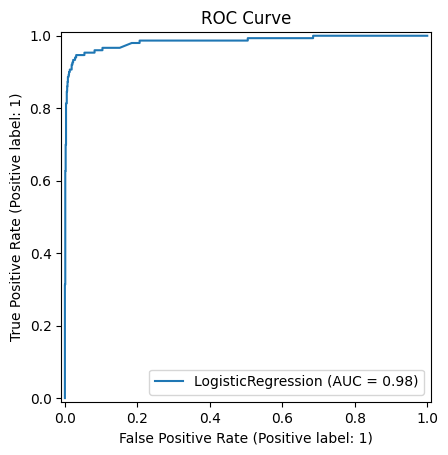

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


best_model = models["Logistic Regression"]
ConfusionMatrixDisplay.from_estimator(best_model, X_test_vec, y_test)
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test_vec, y_test)
plt.title("ROC Curve")
plt.show()

In [23]:
# Assuming you've already trained best_model (e.g., Logistic Regression with class_weight='balanced')

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Predict on test set
y_pred = best_model.predict(X_test_vec)
y_probs = best_model.predict_proba(X_test_vec)[:, 1]  # Get probability of class "1" (spam)

# Print Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print("\nROC AUC Score:", roc_auc)


Accuracy: 0.9757847533632287

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.92      0.90      0.91       150

    accuracy                           0.98      1115
   macro avg       0.95      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
 [[953  12]
 [ 15 135]]

ROC AUC Score: 0.9844006908462868


# 8. Save Final Model

In [24]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(best_model, 'spam_classifier.pkl')

['spam_classifier.pkl']

# 9. Custom Prediction

In [25]:
def predict_message(msg, threshold=0.3):
    cleaned = preprocess(msg)
    vec = tfidf.transform([cleaned])
    prob = best_model.predict_proba(vec)[0][1]
    print(f"Spam Probability: {prob:.2f}")
    return "Spam" if prob > threshold else "Not Spam"


In [26]:
print(predict_message("Congratulations! You've won $1000 Walmart gift card. Click here to claim."))


Spam Probability: 0.71
Spam


In [27]:
spam_messages = [
    "Congratulations! You've been selected to win a free iPhone. Click the link to claim now.",
    "You have won ₹10,00,000 in the lucky draw! Claim your prize now.",
    "URGENT: Your account has been suspended. Click here to verify your information.",
    "FREE entry into our weekly $1000 giveaway! Reply YES to enter.",
    "Get cheap loans now! No credit check required. Limited time offer.",
    "Hot singles in your area are waiting for you. Click to meet now.",
    "Dear user, you have a pending refund of ₹2,500. Click here to receive.",
    "Earn ₹50,000/week from home! Sign up now for your free trial.",
    "Your Paytm KYC is incomplete. Click the link to update immediately.",
    "Final reminder: You have an unclaimed Amazon gift card worth ₹2000!"
]


In [28]:
ham_messages = [
    "Hey, are we still meeting for lunch today at 1 PM?",
    "Don't forget to bring your laptop for the presentation tomorrow.",
    "Good morning! Just wanted to check in and see how you're doing.",
    "Can you please send me the notes from yesterday’s class?",
    "I'll be late to the meeting, stuck in traffic. Sorry!"
]


In [29]:
print("🔴 SPAM MESSAGES:\n")
for msg in spam_messages:
    print(f"> {msg}")
    print("Prediction:", predict_message(msg))
    print("-" * 50)

print("\n🟢 HAM MESSAGES:\n")
for msg in ham_messages:
    print(f"> {msg}")
    print("Prediction:", predict_message(msg))
    print("-" * 50)


🔴 SPAM MESSAGES:

> Congratulations! You've been selected to win a free iPhone. Click the link to claim now.
Spam Probability: 0.96
Prediction: Spam
--------------------------------------------------
> You have won ₹10,00,000 in the lucky draw! Claim your prize now.
Spam Probability: 0.93
Prediction: Spam
--------------------------------------------------
> URGENT: Your account has been suspended. Click here to verify your information.
Spam Probability: 0.73
Prediction: Spam
--------------------------------------------------
> FREE entry into our weekly $1000 giveaway! Reply YES to enter.
Spam Probability: 0.89
Prediction: Spam
--------------------------------------------------
> Get cheap loans now! No credit check required. Limited time offer.
Spam Probability: 0.48
Prediction: Spam
--------------------------------------------------
> Hot singles in your area are waiting for you. Click to meet now.
Spam Probability: 0.47
Prediction: Spam
----------------------------------------------

In [30]:
import pandas as pd

test_msgs = spam_messages + ham_messages
results = [predict_message(msg) for msg in test_msgs]

df_test = pd.DataFrame({
    'Message': test_msgs,
    'Predicted Label': results
})

df_test.head(15)


Spam Probability: 0.96
Spam Probability: 0.93
Spam Probability: 0.73
Spam Probability: 0.89
Spam Probability: 0.48
Spam Probability: 0.47
Spam Probability: 0.54
Spam Probability: 0.56
Spam Probability: 0.55
Spam Probability: 0.50
Spam Probability: 0.08
Spam Probability: 0.14
Spam Probability: 0.05
Spam Probability: 0.15
Spam Probability: 0.04


,Message,Predicted Label
0,Congratulations! You've been selected to win a...,Spam
1,"You have won ₹10,00,000 in the lucky draw! Cla...",Spam
2,URGENT: Your account has been suspended. Click...,Spam
3,FREE entry into our weekly $1000 giveaway! Rep...,Spam
4,Get cheap loans now! No credit check required....,Spam
5,Hot singles in your area are waiting for you. ...,Spam
6,"Dear user, you have a pending refund of ₹2,500...",Spam
7,"Earn ₹50,000/week from home! Sign up now for y...",Spam
8,Your Paytm KYC is incomplete. Click the link t...,Spam
9,Final reminder: You have an unclaimed Amazon g...,Spam
